# Create a map of Countries with current travel restrictions

**Define and get the website (estonian version)**

We are using [requests](https://requests.readthedocs.io/en/master/) to download the webpage, and the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) package to parse the source code of the webpage.

In [2]:
import requests
from bs4 import BeautifulSoup

url = r'https://vm.ee/et/teave-riikide-ja-liikumispiirangute-kohta-eestisse-saabujatele'

r = requests.get(url)
soup = BeautifulSoup(r.text, features="html.parser")

**Regex to find dates and current timeframe**

The data on the website is subject to change. The format can change with a new update, so the information we are looking for might be in a different position, or it has to be extracted from text. Right now, the website stores the last-update information on and the valid time frame in the text, in the format of: 

```DD.MM-DD.MM.YYYY (seisuga DD.MM.YYYY)```

The text might change at some point, but for now we can use regular expressions to extract the data.

In [3]:
import re

These are the too regular expressions we need. The first one extracts the time the data has been released/updated. The second contains the time interval of validity. Regular expression have been drafted on [RegExr](https://regexr.com/). Note, that as soon the text changes on the webite, the regular expression might need to be updated. They are somewhat dynamic (leading 0), but not entirely.

In [4]:
# Compiling to search for "seisuga DD.MM.YYYY"
p1 = re.compile(r'seisuga\s+((?:[0]?[1-9]|[1|2][0-9]|[3][0|1])[.](?:[0]?[1-9]|[1][0-2])[.](?:[0-9]{4}|[0-9]{2}))?')

# Compiling to search for "DD.MM-DD.MM.YYYY"
p2 = re.compile(r'((?:[0]?[1-9]|[1|2][0-9]|[3][0|1])[.](?:[0]?[1-9]|[1][0-2])[.]?(?:[0-9]{4}|[0-9]{2})?)-\s*((?:[0]?[1-9]|[1|2][0-9]|[3][0|1])[.](?:[0]?[1-9]|[1][0-2])[.](?:[0-9]{4}|[0-9]{2}))?')

Finding and parsing the Dates.

In [5]:
import datetime
from dateutil.parser import parse

li = soup.find(text=p1) # look for list entries (explanation below)

# Day of release (last update)
up_date = datetime.datetime.strptime(p1.findall(li)[0], '%d.%m.%Y')

# Validity period
valid_from = parse(p2.findall(li)[0][0])
valid_to = parse(p2.findall(li)[0][1])

# Print to check if it has been extracted properly
print("The website has been updated on {}, the current values are valid from {} to {}.".format(up_date.strftime('%d.%m.%Y'), 
                                                                                             valid_from.strftime('%d.%m.%Y'),
                                                                                             valid_to.strftime('%d.%m.%Y')))

The website has been updated on 18.09.2020, the current values are valid from 21.09.2020 to 27.09.2020.


## Finding countries in the text

In the config.py file in the same folder a dictionary has been created containing all the countries, their English and Estonian translation, matched together by their 2-digit Country code. ([en](https://en.wikipedia.org/wiki/ISO_3166-1), [ee](https://et.wikipedia.org/wiki/ISO_maakoodide_loend)).

The file can be imported as a package, and the containing dictionary is assigned to a variable.

In [6]:
import config as cfg
a2_dct = cfg.a2_dct

dict(list(a2_dct.items())[0:5])

{'AF': {'ee': 'Afganistan', 'en': 'Afghanistan'},
 'AX': {'ee': 'Ahvenamaa', 'en': 'Åland Islands'},
 'AL': {'ee': 'Albaania', 'en': 'Albania'},
 'DZ': {'ee': 'Alžeeria', 'en': 'Algeria'},
 'AS': {'ee': 'Ameerika Samoa', 'en': 'American Samoa'}}

### Finding the section containing EU-countries

The webpage has different sections, which are all subject to change. The sections are defined by [```<ul>```-tags](https://www.w3schools.com/tags/tag_ul.asp) (unordered lists), containing [```<li>```-items](https://www.w3schools.com/tags/tag_li.asp) (list items). We can use BeautifulSoup to find the unordered lists in the website.

In [7]:
uls = soup.find_all('ul')
ils = soup.find_all('li')
print("There are {} unordered lists defined in the website, in total they contain {} list items.".format(len(uls),len(ils)))

There are 33 unordered lists defined in the website, in total they contain 233 list items.


At this stage a bit of manual data exploration is advised. We need to find the unordered list, which contains the data we are looking for (list of EU-countries and their respective active cases / 100k inhabitants). This can certainly be automized, but as long it doesn't change permanently, it is easier to just select the right list. 

In [8]:
# The list we are after is currently the 20 list out of 33.
ul1 = soup.find_all('ul')[20]
ul1

<ul>
<li><span class="node-text-color-red"><strong>Andorra 313,7</strong></span></li>
<li><span class="node-text-color-red"><strong>Austria 88,9</strong></span></li>
<li><span class="node-text-color-red"><strong>Belgia 93,4</strong></span></li>
<li><span class="node-text-color-red"><strong>Bulgaaria 27,5</strong></span></li>
<li><span class="node-text-color-red"><strong>Hispaania 292,2</strong></span></li>
<li><span class="node-text-color-red"><strong>Holland 90,2</strong></span></li>
<li><span class="node-text-color-red"><strong>Horvaatia 78,1</strong></span></li>
<li><span class="node-text-color-red"><strong>Iirimaa 57,4</strong></span></li>
<li>
<p><span class="node-text-color-red"><strong>Island 21,9</strong></span></p>
</li>
<li><span class="node-text-color-red"><strong>Itaalia 33,3</strong></span></li>
<li><span class="node-text-color-red"><strong>Kreeka 31,7</strong></span></li>
<li><strong>Küpros 6,9</strong></li>
<li><span class="node-text-color-red"><strong>Leedu 18,8**</stro

In the printed section we can find all the data we are looking for. Unfortunately the formatting is not homogeneous, which will make extraction a bit more tedious. There are different ```<span>``` classes, and various use cases of the ```<strong>``` tag, which indicate whether the 2-week quarantine rule applies or not. 

#### Regular expressions

Before we are going to loop through all the countries, we are testing our detection. The following command is used to find the country and the number. Note, that the regular expression contains the option for several spaces ```\s*``` (sometimes there is more than one), and the option for decimal number or not ```([,]\d)?```.

In [9]:
cntry = 'Prantsusmaa'
p1 = re.compile( cntry + '\s*[\d]{1,3}([,]\d)?')
res = ul1.find(text=p1)
res

'Prantsusmaa 172,1'

In the next step we want to extract the decimal value. At the same time we can look for a present asterisk, highlighting that there is a special treatment for this case. 

In [10]:
p2 = re.compile(r'(\d*\,?\d+)(\*)?')
res2 = p2.findall(res)[0]
res2

('172,1', '')

In case the country is highlighted in<font color=red> **bold and red ** </font> returning from the country implies a 14 day quarantine period. Whether or not the formatting exists can be checked like this.

In [11]:
if res.find_parent('span', {'class': 'node-text-color-red'}):
    print(True)
    
# or 
if res.find_parent('strong', {'style' : 'color: rgb(189, 73, 50);'}):
    print(True)

True


#### Looping through the data

In [12]:
# Creating dictionaries and lists where the collected information is stored
a2_status = {}  # 
found_countries = [] # countries that were found on the webpage
quarantine = [] # countries needing quarantine on re-entry
no_quarantine = [] # countries without quarantine rule

In [13]:
for a2 in a2_dct.keys(): # looping through all country codes
    cntry = a2_dct[a2]['ee'] # get the estonian translation
    cntry_en = a2_dct[a2]['en'] # get the english translation
    
    # find the country in the selected unordered list
    p1 = re.compile( cntry + '\s*[\d]{1,3}([,]\d)?') # see explanation above
    res1 = ul1.find(text=p1) 
    
    if res1: # if it is found
        found_countries.append(cntry_en) # append it to the list of countries found
        
        #p2 = re.compile(r'(\d*\,?\d+)(\*)?') # 
        res2 = p2.findall(res1)[0] # search for the value (see above)
        val = float(res2[0].replace(',','.')) # convert value from string decimal (komma) to float
        a2_status[a2] = {'val': val} # assign it to the dictionary
        
        # the following is checking whether a asterisk is present 
        note = res2[0][1]
        if note == '':
            a2_status[a2]['note'] = False # assign to the dictionary
        else:
            a2_status[a2]['note'] = True
            
        #print(res, val, end = '')
        
        # check whether quarantine rules apply or not
        if res1.find_parent('span', {'class': 'node-text-color-red'}) or res1.find_parent('strong', {'style' : 'color: rgb(189, 73, 50);'}):
            #print('####')
            a2_status[a2]['fom'] = False # assign to the dictionary
            quarantine.append(cntry_en) # add to the list of countries that need to quarantine
        else:
            #print('')
            a2_status[a2]['fom'] = True
            no_quarantine.append(cntry_en) # add to the list of countries that do not need to quarantine
            
        fom = 'FOM restricted' if not a2_status[a2]['fom'] else ''
        print('{}: {} {}'.format(cntry, a2_status[a2]['val'], fom))
        del res2    
    else:
        pass
    del res1

Andorra: 313.7 FOM restricted
Austria: 88.9 FOM restricted
Belgia: 93.4 FOM restricted
Bulgaaria: 27.5 FOM restricted
Hispaania: 292.2 FOM restricted
Holland: 90.2 FOM restricted
Horvaatia: 78.1 FOM restricted
Iirimaa: 57.4 FOM restricted
Island: 21.9 FOM restricted
Itaalia: 33.3 FOM restricted
Kreeka: 31.7 FOM restricted
Küpros: 6.9 
Leedu: 18.8 FOM restricted
Liechtenstein: 7.8 
Luksemburg: 129.7 FOM restricted
Läti: 4.4 
Malta: 127.2 FOM restricted
Norra: 27.5 FOM restricted
Poola: 19.6 FOM restricted
Portugal: 71.5 FOM restricted
Prantsusmaa: 172.1 FOM restricted
Rootsi: 30.3 FOM restricted
Rumeenia: 89.8 FOM restricted
Saksamaa: 24.3 FOM restricted
San Marino: 23.2 FOM restricted
Slovakkia: 34.1 FOM restricted
Sloveenia: 48.9 FOM restricted
Soome: 10.9 
Šveits: 65.0 FOM restricted
Taani: 69.2 FOM restricted
Tšehhi: 166.2 FOM restricted
Ungari: 94.0 FOM restricted
Vatikan: 0.0 
Ühendkuningriik: 61.8 FOM restricted


### Finding other listed countries

Same approach here, but it is not necessary to look for the active cases per country.

In [14]:
ul2 = soup.find_all('ul')[21] # define the unordered list to look for countries (currently #21, but it might change)
for a2 in a2_dct.keys(): # looping through all country codes
    cntry = a2_dct[a2]['ee'] # get the estonian translation
    cntry_en = a2_dct[a2]['en'] # get the english translation
    
    # find the country in the selected unordered list
    # also check if a asterisk is present (=quarantine mandatory)
    p1 = re.compile('(' + cntry + ')\s*([\*])?') # see explanation above
    res1=p1.findall(ul2.text)
    
    if res1: # if it is found
        a2_status[a2] = {'val': None} # assign None value to the respective country 
        found_countries.append(cntry_en)  # append it to the list of countries found
        note = res1[0][1]
        if note =='':
            a2_status[a2]['fom'] = False
            quarantine.append(cntry_en)
        else:
            a2_status[a2]['fom'] = True
            no_quarantine.append(cntry_en)
            
        a2_status[a2]['note'] = False
        
        fom = 'FOM restricted' if not a2_status[a2]['fom'] else ''
        print('{} {}'.format(cntry, fom))

    else:
        pass
    del res1

Austraalia FOM restricted
Gruusia FOM restricted
Jaapan FOM restricted
Kanada 
Lõuna-Korea FOM restricted
Rwanda FOM restricted
Tai FOM restricted
Tuneesia 
Uruguay FOM restricted
Uus-Meremaa FOM restricted


Give out a quick report.

In [15]:
print('Found countries: {}'.format(len(found_countries)))

print('Countries that need quarantine: {}'.format(len(quarantine)))
print(quarantine)
print('Countries that need NO quarantine: {}'.format(len(no_quarantine)))
print(no_quarantine)

Found countries: 44
Countries that need quarantine: 37
['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Spain', 'Netherlands', 'Croatia', 'Ireland', 'Iceland', 'Italy', 'Greece', 'Lithuania', 'Luxembourg', 'Malta', 'Norway', 'Poland', 'Portugal', 'France', 'Sweden', 'Romania', 'Germany', 'San Marino', 'Slovakia', 'Slovenia', 'Switzerland', 'Denmark', 'Czechia', 'Hungary', 'United Kingdom', 'Australia', 'Georgia', 'Japan', 'Korea, Republic of', 'Rwanda', 'Thailand', 'Uruguay', 'New Zealand']
Countries that need NO quarantine: 7
['Cyprus', 'Liechtenstein', 'Latvia', 'Finland', 'Holy See', 'Canada', 'Tunisia']


Add additional key for UK.

In [16]:
a2_status['GB'] = a2_status['UK'] # The two letter codes were not consistent

{'AD': {'val': 313.7, 'note': True, 'fom': False},
 'AT': {'val': 88.9, 'note': True, 'fom': False},
 'BE': {'val': 93.4, 'note': True, 'fom': False},
 'BG': {'val': 27.5, 'note': True, 'fom': False},
 'ES': {'val': 292.2, 'note': True, 'fom': False}}

Show the first entries of the dictionary with the results. 

In [44]:
dict(list(a2_status.items())[0:5])

{'AD': {'val': 313.7, 'note': True, 'fom': False},
 'AT': {'val': 88.9, 'note': True, 'fom': False},
 'BE': {'val': 93.4, 'note': True, 'fom': False},
 'BG': {'val': 27.5, 'note': True, 'fom': False},
 'ES': {'val': 292.2, 'note': True, 'fom': False}}

#### Get data for Estonia

No data is present for Estonia on the vm.ee website. 

In the next steps we pull the data from another feature layer, whose data collection has been documented [here](https://github.com/MBennGit/agcovdemo/blob/master/01_Download_and_Preprocess_Data.ipynb)

Load ArcGIS API for Python and log in.

In [45]:
from arcgis.gis import GIS
#gis = GIS(username="user1", password="password", profile="COVDemo") # uncomment to log in and safe as a profile.
gis = GIS(profile="COVDemo")

Get the feature layer collection.

<Item title:"Eesti_maakond_koroona_tsp" type:Feature Layer Collection owner:MBennTLL>
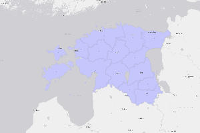

In [46]:
flcid = '25c87bbbd5b54234a3f5905066569b96'
flc = gis.content.get(flcid)
flc

Query the first layer of the feature layer collection (getting the most recent data).

Convert the data to a spatially enabled dataset.

In [50]:
ts_lyr = flc.layers[0] # get the first layer (it only contains one)
ts_fset = ts_lyr.query(where="lastFeature=1") # query it without a query, to select all data
ts_df = ts_fset.sdf[['MNIMI', 'activeCases', 'Population']] # save data to spatially enabled dataset
ts_df

,MNIMI,activeCases,Population
0,Pärnumaa,2,88125
1,Saaremaa,4,33984
2,Lääne-Virumaa,8,60891
3,Harjumaa,235,611002
4,Viljandimaa,1,47778
5,Tartumaa,16,157015
6,Jõgevamaa,2,29640
7,Põlvamaa,1,25894
8,Ida-Virumaa,146,140302
9,Võrumaa,10,37012


In the next step we sum the active cases (last 14 days), by the sum of the population.

In [58]:
aC = ts_df.activeCases.sum()
Pop = ts_df.Population.sum()
ee_val = round((aC / Pop ) * 100000, 1)

print(
f"Estonia has {aC} active Cases. The population is {Pop}. \n\
This equals {ee_val} cases per 100k inhabitants in the last 14 days."
)

Estonia has 438 active Cases. The population is 1356805. 
This equals 32.3 cases per 100k inhabitants in the last 14 days.


Saving back to the dictionary.

In [59]:
a2_status['EE'] = {'val': ee_val, 'note': False, 'fom': True}

#### Add exemption for Finland, Latvia, Lithuania

In [23]:
for a2 in ['FI', 'LV', 'LT']:
    val = a2_status[a2]['val']
    if val < 25:
        a2_status[a2]['fom'] = True

## Push results to ArcGIS Online

Load the necessary packages. 

In [24]:
from copy import deepcopy
import pytz
from dateutil.tz import tzlocal

Log in to ArcGIS Online. 

In [25]:
#gis = GIS(username="user1", password="password", profile="COVDemo") # uncomment to log in and safe as a profile.
gis = GIS(profile="COVDemo")

Get the Feature Layer Collection that we want to edit. (It has been created before, click the link to check out the data structure.)

<Item title:"Covid19 Teave riikide" type:Feature Layer Collection owner:MBennTLL>
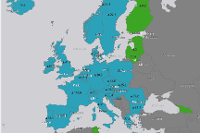

In [26]:
current_id = r'abe1b723785f4ecfbb602697d50872a0'
flc = gis.content.get(current_id)
flc

In [27]:
flayer = flc.layers[0] # get the first layer (it only contains one)
fset = flayer.query() # query it without a query, to select all data
sdf = fset.sdf # save data to spatially enabled dataset

all_features = fset.features # save all the feautres to a list as json objects
print("Retrieved {} features from feature set".format(len(all_features)))

Retrieved 256 features from feature set


**Do the following steps in loop.**

1. Check whether the new data is more recent than the previously stored.
2. Loop through all ISO 2 digit values in feature set
    1. Find all features with said code
    2. Remove geometries, to reduce processing time and traffic
    3. Check whether the 2-digit code is also to be found in the previously created dictionary
        1. YES: copy values from dictionary to the feature
        2. NO: reset all values to None/Null values
    4. Add the feature to the list of feature that need to be updated


In [28]:
import pandas as pd

In [29]:
features_to_update = [] # create empty list with features that will be updated.

# check if new data is more recent than the last data
if pd.isnull(sdf.lastUpdate.max()) or up_date.astimezone(pytz.utc) > sdf.lastUpdate.max().replace(tzinfo=pytz.utc): # 
    for a2 in sdf.ISO_2DIGIT.values: # go through all the 2-digit codes in the feature set
        original_features = [f for f in all_features if f.attributes['ISO_2DIGIT'] == a2] # query to find the feature(s)
        for original_feature in original_features: # some countries contain more than one polygon
            feature_to_be_updated = deepcopy(original_feature) # copy the original
            del feature_to_be_updated.attributes['SHAPE'] # delete shape temporarily (does not need to be updated)
            
            if a2 in a2_status: # check whether the code exist in previously created dictionary
                curVal = a2_status[a2]['val'] # get current value from dictionary
                prevVal = feature_to_be_updated.attributes['activeCasesp100k'] # save previous value
                feature_to_be_updated.attributes['activeCasesp100k'] = curVal # set current 
                feature_to_be_updated.attributes['prevActiveCp100k'] = prevVal # set previous 
                feature_to_be_updated.attributes['addInfo'] = int(a2_status[a2]['note']) # set 0/1 if there is a note
                feature_to_be_updated.attributes['StatusCode'] = 1 if a2_status[a2]['fom'] else 2 # set Status depending on FOM
                feature_to_be_updated.attributes['prevUpdate'] = feature_to_be_updated.attributes['lastUpdate'] # set last update 
                feature_to_be_updated.attributes['lastUpdate'] = up_date # set to date extracted from text 
                feature_to_be_updated.attributes['validFrom'] = valid_from # set to period extracted from text 
                feature_to_be_updated.attributes['validTo'] = valid_to # set to period extracted from text 
                if prevVal and curVal:
                    feature_to_be_updated.attributes['activeCasesTrend'] = 1 if round(prevVal,1) < round(curVal,1) else 2
                else:
                    feature_to_be_updated.attributes['activeCasesTrend'] = 0
            else:
                # set everything to none except previous values
                feature_to_be_updated.attributes['activeCasesp100k'] = None
                feature_to_be_updated.attributes['prevActiveCp100k'] = feature_to_be_updated.attributes['activeCasesp100k']
                feature_to_be_updated.attributes['addInfo'] = None
                feature_to_be_updated.attributes['StatusCode'] = 9
                feature_to_be_updated.attributes['prevUpdate'] = feature_to_be_updated.attributes['lastUpdate']
                feature_to_be_updated.attributes['lastUpdate'] = None
                feature_to_be_updated.attributes['validFrom'] = None
                feature_to_be_updated.attributes['validTo'] = None
                feature_to_be_updated.attributes['activeCasesTrend'] = 0
            # remove the feature geometry by keeping the attributes only   
            feature_to_be_updated2 = {}
            feature_to_be_updated2['attributes'] = feature_to_be_updated.attributes
            features_to_update.append(feature_to_be_updated2) # append the updated attributes
    result = flayer.edit_features(updates=features_to_update) # update the data online